# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察填補缺值以及 標準化 / 最小最大化 對數值的影響

# [作業重點]
- 觀察替換不同補缺方式, 對於特徵的影響 (In[4]~In[6], Out[4]~Out[6])
- 觀察替換不同特徵縮放方式, 對於特徵的影響 (In[7]~In[8], Out[7]~Out[8])

# [缺失值填補]

* 先判斷為零（所以才沒填東西）的可能性（用領域知識想缺失代表的意義），接下來看非缺失值的欄位資料分佈，再判斷要怎麼填入
* 填補缺失值時注意不要破壞資料的分佈
* 填補統計值: 
    - 填補平均值(Mean) : 數值型欄位，偏態不明顯
    - 補中位數(Median) : 數值型欄位，偏態很明顯 
    - 填補眾數(Mode) : 類別型欄欄位
    - #使用price均值对NA进行填充 #df['price'].fillna(df['price'].mean())#df['price'].fillna(df['price'].median())
* 填補指定值 - 需對欄欄位領域知識已有了解 
    - 0 : 空缺原本就有 0 的含意，如前⾴頁的房間數
    - 補不可能出現的數值 : 類別型欄欄位，但不適合⽤用眾數時
* 填補預測值 - 速度較慢但精確，從其他資料欄欄位學得填補知識
    - 若填補範圍廣，且是重要特徵欄欄位時可⽤方式 
    - 本方式須提防overfitting : 可能退化成為其他特徵的組合

# [標準化及最大最小化]

* 標準化 : 以合理的⽅式，平衡特徵間的影響⼒
* 使用時機：
    - 標準化 (Standard Scaler) : 假定數值為常態分佈，適合本方式平衡特徵
    - 最大最小化 (MinMax Scaler) : 假定數值為均勻分佈，適合本方式平衡特徵
* 使用差異：
    - 標準化較不容易受到極端值影響
    - 最大最小化易受極端值影響 (去過離群值的才比較適合使用最大最小化）
    - 非樹狀模型易受到使否有使用標準化跟最大最小化的影響
    - 樹狀模型不會受到是否有採用這兩種方法的影響


In [1]:
# 做完特徵工程前的所有準備 
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = 'Part02/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



In [3]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
train_num = train_Y.shape[0]
df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
* 試著在補空值區塊, 替換並執行兩種以上填補的缺值, 看看何者比較好?

In [4]:
# 先檢查欄位缺值數量 
df.isnull().sum().sort_values(ascending=False) #因資料幾乎只有age有缺失值，所以直接做而不分開做

Age       263
Fare        1
Parch       0
SibSp       0
Pclass      0
dtype: int64

In [6]:
# 空值補 -1, 做羅吉斯迴歸
df_m1 = df.fillna(df.median()) #發現median的準確度最高，再來為mean。原因應該是資料有偏向0的趨勢
train_X = df_m1[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()


/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

0.6992934218081011

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

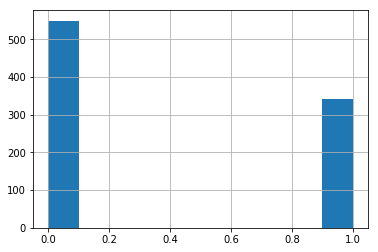

In [8]:
train_Y.hist() #看到資料稍微偏向0 #其實可以直接用value_counts的

# 作業2
* 使用不同的標準化方式 ( 原值 / 最小最大化 / 標準化 )，搭配羅吉斯迴歸模型，何者效果最好?

In [9]:
#先用最大最小化 #但其實不會有差哈哈哈哈，因為本來就是0跟1
df_ml = df.fillna(df.median())
df_ml = MinMaxScaler().fit_transform(df_ml)
train_X = df_m1[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will

0.6992934218081011

In [12]:
#用標準化 
df_ml_1 = df.fillna(df.median())
df_ml_1 = StandardScaler().fit_transform(df_ml_1)
train_X = df_ml_1[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()


/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rikeion/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: De

0.6970587140092496